<a href="https://colab.research.google.com/github/zhaoxjmail/Abnormal-check/blob/master/%5BHands_On%5D_Understanding_Masking_in_Transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [Hands-On] Understanding Masking in Transformers
- Author : Sangkeun Jung (hugmanskj@gmail.com)

> Educational Purpose

**Copyright**: All rights reserved

---

## Overview

Masking is a crucial technique in deep learning, particularly in transformer-based architectures, that allows us to selectively ignore certain parts of the input during processing. It serves several important purposes:

1. Handling variable-length sequences by padding them to the same length
2. Preventing information leakage in sequence generation tasks
3. Controlling the flow of information in attention mechanisms

The two main types of masking we'll explore are:
- Padding masks (attention masks) - for handling variable-length sequences
- Look-ahead masks - for maintaining causality in sequence generation

## Understanding softmax behavior

The softmax function is used to convert a vector of scores into probabilities. The formula for the softmax function applied to a vector \( \mathbf{z} \) is:

$$
\text{softmax}(z_i) = \frac{e^{z_i}}{\sum_{j=1}^n e^{z_j}}
$$

where:

- $ z_i $ is the $ i $-th element of the input vector $ \mathbf{z} $,
- $ e^{z_i} $ is the exponential function applied to $ z_i $,
- the denominator $ \sum_{j=1}^n e^{z_j} $ is the sum of exponentials of all elements in $ \mathbf{z} $, ensuring that the output is normalized (i.e., all outputs sum up to 1).

This function emphasizes higher values more while suppressing smaller values, making it useful for probability distributions.

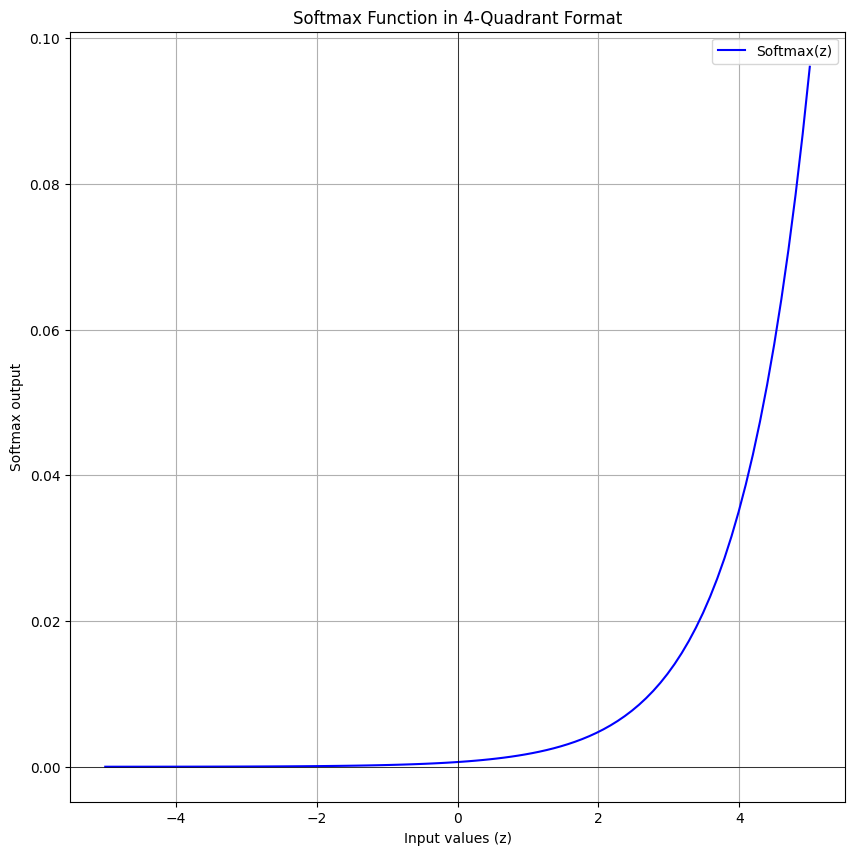

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Code to plot the softmax function in a 4-quadrant form with both negative and positive input values

# Define a range of values for z that includes both negative and positive values
z_values = np.linspace(-5, 5, 100)
# Create a matrix where each row is the softmax values for each z value treated as an individual vector
softmax_matrix = np.exp(z_values) / np.sum(np.exp(z_values))

# Plotting in a 4-quadrant format
plt.figure(figsize=(10, 10))
plt.plot(z_values, softmax_matrix, label="Softmax(z)", color="blue")

# Adding axis lines for 4-quadrant visualization
plt.axhline(0, color='black',linewidth=0.5)
plt.axvline(0, color='black',linewidth=0.5)

# Adding titles and labels
plt.title("Softmax Function")
plt.xlabel("Input values (z)")
plt.ylabel("Softmax output")
plt.legend()
plt.grid(True)

# Display plot
plt.show()


## Pad Masking with Attention-Mask

Pad masking, also known as attention masking, is essential when dealing with variable-length sequences in batch processing. In natural language processing and other sequence-based tasks, we often need to pad shorter sequences to match the length of the longest sequence in a batch.

Key points about pad masking:

1. **Purpose**:
   - Prevents the model from attending to padding tokens
   - Ensures the attention mechanism only considers valid input tokens
   - Maintains the integrity of the attention computation

2. **Implementation**:
   - Uses binary masks (1 for valid tokens, 0 for padding)
   - Converts 0s to negative infinity before softmax
   - After softmax, padded positions receive effectively zero attention weight

3. **Effect**:
   - Valid tokens can attend to other valid tokens
   - Padding tokens are completely ignored in attention computations
   - Preserves the semantic meaning of the original sequence

In [ ]:
import numpy as np
import torch
import torch.nn.functional as F

# Step 1: Define the attention mask manually based on the image
# 1 represents positions that are not masked, 0 represents masked positions
mask = torch.tensor([
    [1, 1, 1, 0],
    [1, 1, 0, 0],
    [1, 1, 1, 1],
    [1, 1, 0, 0]
], dtype=torch.float32)

# Step 2: Convert the mask into a form compatible with masking
# Convert 1s to 0 (unmasked), and 0s to -inf (masked)
mask = mask.masked_fill(mask == 0, float('-inf'))
mask = mask.masked_fill(mask == 1, 0)

# Step 3: Generate a random 4x4 matrix of scores
scores = torch.rand(4, 4)
print("Original Scores (before softmax):")
print(scores)

# Step 4: Apply the mask to the scores
masked_scores = scores + mask
print("\nMasked Scores (before softmax):")
print(masked_scores)

# Step 5: Apply softmax along rows
softmax_scores = F.softmax(masked_scores, dim=-1)
print("\nFinal Scores (after softmax):")
print(softmax_scores)


Original Scores (before softmax):
tensor([[0.6771, 0.2913, 0.2460, 0.8949],
        [0.0212, 0.4826, 0.1221, 0.4218],
        [0.0257, 0.0235, 0.2420, 0.7532],
        [0.7657, 0.4715, 0.8280, 0.1759]])

Masked Scores (before softmax):
tensor([[0.6771, 0.2913, 0.2460,   -inf],
        [0.0212, 0.4826,   -inf,   -inf],
        [0.0257, 0.0235, 0.2420, 0.7532],
        [0.7657, 0.4715,   -inf,   -inf]])

Final Scores (after softmax):
tensor([[0.4293, 0.2918, 0.2789, 0.0000],
        [0.3867, 0.6133, 0.0000, 0.0000],
        [0.1884, 0.1879, 0.2338, 0.3899],
        [0.5730, 0.4270, 0.0000, 0.0000]])


## Look-ahead Masking

Look-ahead masking, also known as causal masking or future masking, is crucial for autoregressive sequence generation tasks, such as language modeling or machine translation.

Key aspects of look-ahead masking:

1. **Purpose**:
   - Prevents the model from accessing future information
   - Ensures autoregressive property in sequence generation
   - Maintains causality in the attention mechanism

2. **Implementation**:
   - Creates a lower triangular matrix
   - Allows each position to attend only to previous positions and itself
   - Masks out (sets to negative infinity) all future positions

3. **Applications**:
   - Language modeling
   - Text generation
   - Any task requiring sequential prediction

In [ ]:
import torch
import torch.nn.functional as F

# Step 1: Generate a random 4x4 matrix of scores
scores = torch.rand(4, 4)
print("Original Scores (before softmax):")
print(scores)

# Step 2: Create the look-ahead mask using the tril function
# tril creates a lower triangular matrix with 1s in positions that are allowed and 0s elsewhere
look_ahead_mask = torch.tril(torch.ones(4, 4))

# Convert the mask: 1s to 0 (unmasked), and 0s to -inf (masked)
look_ahead_mask = look_ahead_mask.masked_fill(look_ahead_mask == 0, float('-inf'))
look_ahead_mask = look_ahead_mask.masked_fill(look_ahead_mask == 1, 0)

# Step 3: Apply the look-ahead mask to the scores
look_ahead_masked_scores = scores + look_ahead_mask
print("\nLook-Ahead Masked Scores (before softmax):")
print(look_ahead_masked_scores)

# Step 4: Apply softmax along rows
look_ahead_softmax_scores = F.softmax(look_ahead_masked_scores, dim=-1)
print("\nLook-Ahead Final Scores (after softmax):")
print(look_ahead_softmax_scores)


Original Scores (before softmax):
tensor([[0.1094, 0.0356, 0.6723, 0.9902],
        [0.9814, 0.2217, 0.3483, 0.1860],
        [0.5827, 0.6277, 0.5062, 0.8404],
        [0.6773, 0.1660, 0.1532, 0.9492]])

Look-Ahead Masked Scores (before softmax):
tensor([[0.1094,   -inf,   -inf,   -inf],
        [0.9814, 0.2217,   -inf,   -inf],
        [0.5827, 0.6277, 0.5062,   -inf],
        [0.6773, 0.1660, 0.1532, 0.9492]])

Look-Ahead Final Scores (after softmax):
tensor([[1.0000, 0.0000, 0.0000, 0.0000],
        [0.6813, 0.3187, 0.0000, 0.0000],
        [0.3364, 0.3519, 0.3117, 0.0000],
        [0.2854, 0.1711, 0.1690, 0.3745]])


## Conclusion

Masking is a fundamental concept in attention-based neural networks that serves multiple crucial purposes:

1. **Efficiency**: Enables batch processing of variable-length sequences through pad masking
2. **Causality**: Ensures proper sequence generation through look-ahead masking
3. **Flexibility**: Allows for different attention patterns based on task requirements

Understanding and properly implementing masking is essential for:
- Building effective transformer-based models
- Handling variable-length sequences
- Maintaining causality in sequence generation tasks
- Optimizing model performance

The combination of pad masking and look-ahead masking enables the development of powerful sequence processing models while maintaining the necessary constraints for each specific task.